##  Script to plot the FCGA output for full FC gradients and thresholded gradients (32k and parcellated)

In [4]:
# ========== Imports ==========
import os
import sys
import re
from collections import OrderedDict
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import importlib.util
from util_fcgaplot import *
# ========== Configuration ==========
# ---- Base Paths ----
BASEPATH = '/Users/dennis.jungchildmind.org/Desktop/To-be-uploaded-to-CMI-server'
downloads_path = '/Users/dennis.jungchildmind.org/Downloads/fcga_result/'

# ---- Analysis Target ----
TARGET_DISTANCE = 'short'  # options: 'short', 'long', 'full'
SAVEPATH = os.path.join(BASEPATH, f'FCGA_results/{TARGET_DISTANCE}')

# ========== Data Files Organization ==========

def extract_mm_value(fname):
    m = re.search(r'(\d+)mm', fname)
    return int(m.group(1)) if m else float('inf')

# Organize DATA_PATHS by value (e.g., 10mm, 20mm...) extracted from the filename,
# only including files matching TARGET_DISTANCE, and sorting them
filtered_files = [fname for fname in os.listdir(downloads_path) if TARGET_DISTANCE in fname]
sorted_files = sorted(filtered_files, key=extract_mm_value)
DATA_PATHS = OrderedDict(
    (f"{extract_mm_value(fname)}mm", os.path.join(downloads_path, fname))
    for fname in sorted_files
)
# Optionally get every other item (unclear intent, but this is in the original code)
DATA_PATHS = dict(list(DATA_PATHS.items())[::2])

# ========== Atlas Setup ==========
atlas_path = os.path.join(
    BASEPATH, 'parcellation', 'Schaefer', 'Schaefer2018_400Parcels_7Networks_order.dlabel.nii'
)
atlas = nib.load(atlas_path).get_fdata()[0].astype(int)
atlas_data_lh = atlas[:len(atlas) // 2]  # left hemisphere split for later use

# ========== Surface Files ==========
lh_roi_surf = os.path.join(BASEPATH, 'HCP_S1200_Atlas_Z4_pkXDZ', 'S1200.L.atlasroi.32k_fs_LR.shape.gii')
lh_surf    = os.path.join(BASEPATH, 'HCP_S1200_Atlas_Z4_pkXDZ', 'S1200.L.white_MSMAll.32k_fs_LR.surf.gii')
rh_surf    = os.path.join(BASEPATH, 'HCP_S1200_Atlas_Z4_pkXDZ', 'S1200.R.white_MSMAll.32k_fs_LR.surf.gii')

# ========== ROI Indices (for left hemisphere) ==========
# Get the atlasroi data for left hemisphere and find nonzero indices
lh_roi_data = nib.load(lh_roi_surf).darrays[0].data
nonzero_indices = np.where(lh_roi_data != 0)[0]


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


###  Main script 1: Generate individual plot for each distance

In [5]:
# --- MAIN EXECUTION ---
for data_name, data_path in DATA_PATHS.items():
    print(data_name)
    #save_path = os.path.join(SAVEPATH,data_name)
    if not os.path.exists(SAVEPATH):
        os.makedirs(SAVEPATH)
    data = np.load(data_path)
    util_import_path = os.path.join(os.getcwd(), "../092325_cortical_gradients/gradient_utils.py")
    gradient_utils = import_gradient_utils(util_import_path)
    fixed_data = fix_data_shape(data, nonzero_indices)#map to correct surface index
    # --- Plotting the gradients (32k vertices) on the surface ---
    fig = plot_gradients(gradient_utils, {0:fixed_data}, lh_surf, n_components=3, cmap='RdBu_r')
    fig.savefig(os.path.join(SAVEPATH, f'{data_name}_gradients_32k.png'))
    plt.close(fig)
    # save the data
    np.save(os.path.join(SAVEPATH, f'{data_name}_gradients_32k.npy'), fixed_data)
    # --- Main Parcellation, Back-projection, and Plotting Workflow ---
    parcellated_data, unique_labels = parcellate_data_matrix(fixed_data, atlas_data_lh, gradient_utils)
    reconstructed_data = backproject_to_surface_from_parcels(parcellated_data, atlas_data_lh, unique_labels)
    fig = plot_gradients_on_surface(gradient_utils, {0:reconstructed_data}, lh_surf, N_components_plot=3, cmap='RdBu_r')
    fig.savefig(os.path.join(SAVEPATH, f'{data_name}_gradients_schaefer400.png'))
    plt.close(fig)
    np.save(os.path.join(SAVEPATH, f'{data_name}_gradients_schaefer400.npy'), parcellated_data)

10mm
Successfully imported from: /Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/layer_project/cortical_layer/jupyter-notebook/092325_cortical_gradients/gradient_utils.py
30mm
Successfully imported from: /Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/layer_project/cortical_layer/jupyter-notebook/092325_cortical_gradients/gradient_utils.py
50mm
Successfully imported from: /Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/layer_project/cortical_layer/jupyter-notebook/092325_cortical_gradients/gradient_utils.py
70mm
Successfully imported from: /Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/layer_project/cortical_layer/jupyter-notebook/092325_cortical_gradients/gradient_utils.py
90mm
Successfully imported from: /Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/layer_project/cortical_layer/jupyter-notebook/092325_cortical_gradient

Context leak detected, msgtracer returned -1


170mm
Successfully imported from: /Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/layer_project/cortical_layer/jupyter-notebook/092325_cortical_gradients/gradient_utils.py
190mm
Successfully imported from: /Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/layer_project/cortical_layer/jupyter-notebook/092325_cortical_gradients/gradient_utils.py


### Main script 2: Combine all generate figures from the previous section

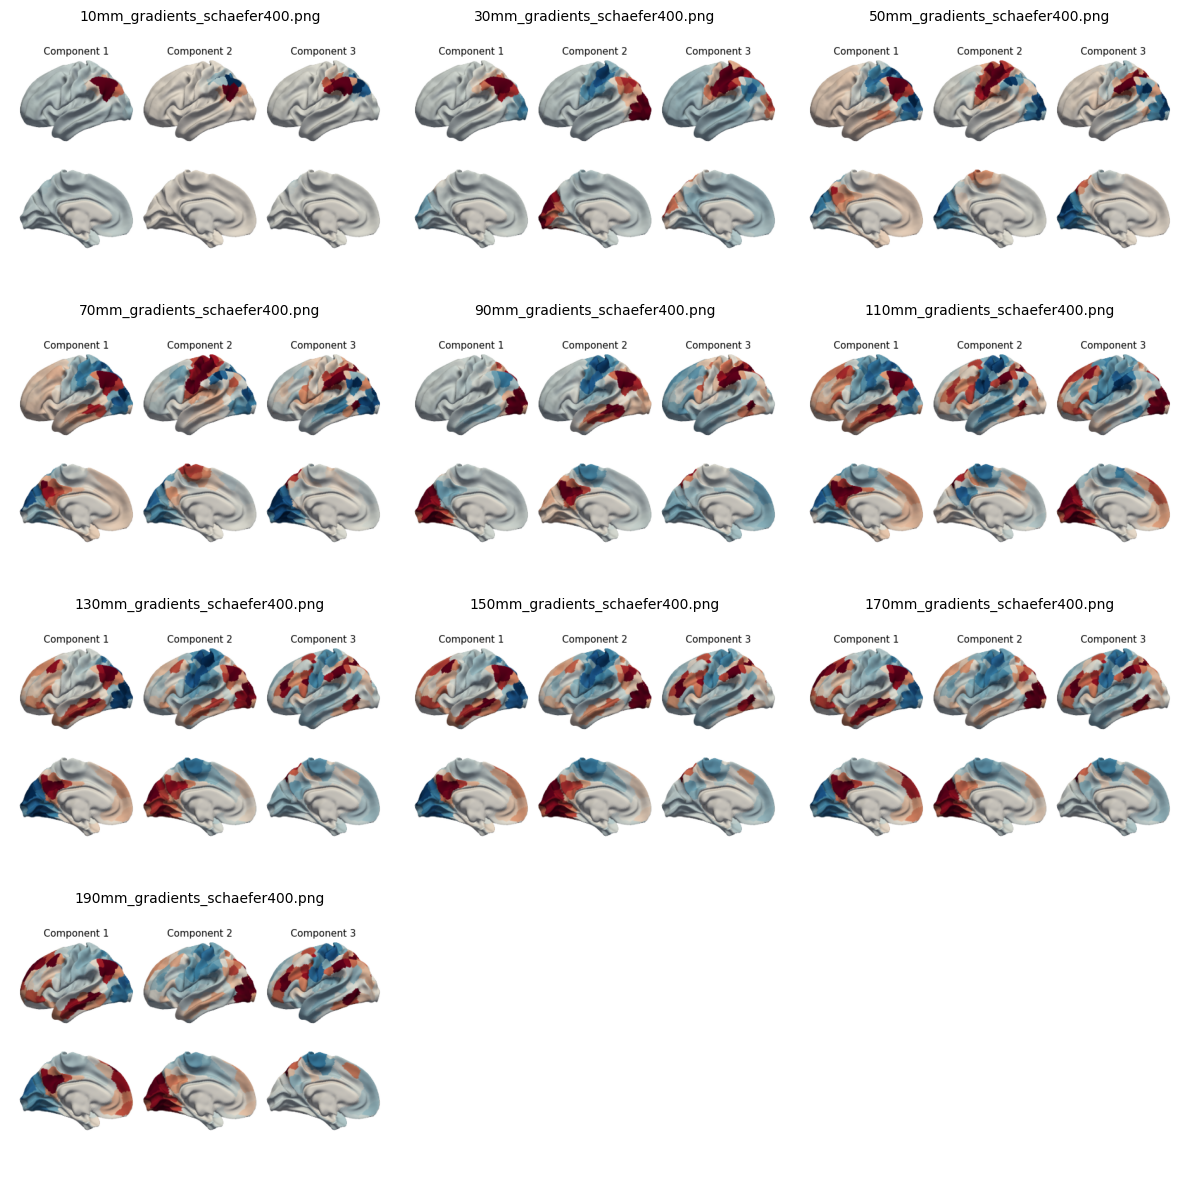

: 

In [ ]:
# Combine only the 32k gradient result figures in a large figure, ordered by mm in filename
import glob
from matplotlib.image import imread
import re

# Get only PNG files in SAVEPATH directory that include '32k' in filename
TARGET_NAME = 'schaefer'# 32k or schaefer
fig_paths = [p for p in glob.glob(os.path.join(SAVEPATH, '*png')) if TARGET_NAME in os.path.basename(p) and 'mm' in os.path.basename(p)]

# Sort paths by mm extracted from filename
fig_paths = sorted(fig_paths, key=lambda x: extract_mm_value(os.path.basename(x)))

n_figs = len(fig_paths)
if n_figs == 0:
    print(f"No {TARGET_NAME} figures found.")
else:
    n_cols = 3 if n_figs >= 4 else n_figs
    n_rows = int(np.ceil(n_figs / n_cols))

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))

    # Ensure axs is always 2D array for easier indexing
    if n_figs == 1:
        axs = np.array([[axs]])
    elif n_rows == 1:
        axs = np.array([axs])
    elif n_cols == 1:
        axs = axs.reshape(-1, 1)

    for idx, fig_path in enumerate(fig_paths):
        row = idx // n_cols
        col = idx % n_cols
        ax = axs[row, col]
        img = imread(fig_path)
        ax.imshow(img)
        ax.set_title(os.path.basename(fig_path), fontsize=10)
        ax.axis('off')

    # Hide unused subplots
    for empty_idx in range(n_figs, n_rows * n_cols):
        row = empty_idx // n_cols
        col = empty_idx % n_cols
        axs[row, col].axis('off')

    plt.tight_layout()  # Reduce vertical (row) spacing
    plt.show()
    #save the figure
    fig.savefig(os.path.join(SAVEPATH, f'{TARGET_NAME}_{TARGET_DISTANCE}_all_figures.png'))
    plt.close(fig)